# word2vec

## Импорт библиотек

In [35]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import re

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Scoring
from sklearn.metrics import accuracy_score, f1_score

import seaborn as sns

import multiprocessing


from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer

%matplotlib inline

## Загрузка данных

In [66]:
#датасет с отзывами по англоязычным курсам
reviews_eng_courses = pd.read_csv('reviews_eng_courses.csv')
reviews_eng_courses.head()

,url,course_id,reviewer_name,rating,review_text
0,https://www.coursera.org/learn/2-speed-it/revi...,2-speed-it,Ravish,5,Very relevant and useful course designed for CIOs
1,https://www.coursera.org/learn/2-speed-it/revi...,2-speed-it,Etienne R,2,This course does not say anything about digiti...
2,https://www.coursera.org/learn/2-speed-it/revi...,2-speed-it,Viswas P,4,Videos that are presented in French could've b...
3,https://www.coursera.org/learn/2-speed-it/revi...,2-speed-it,AN L,3,"The course content is quite good, though it co..."
4,https://www.coursera.org/learn/2-speed-it/revi...,2-speed-it,Konstantin A,5,"Great piece of work, I especially liked a few ..."


In [67]:
reviews_eng_courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160092 entries, 0 to 160091
Data columns (total 5 columns):
url              160092 non-null object
course_id        160092 non-null object
reviewer_name    159841 non-null object
rating           160092 non-null int64
review_text      160085 non-null object
dtypes: int64(1), object(4)
memory usage: 6.1+ MB


In [70]:
#пропущенное имя пользователя делает отзыв бесполезным для наших целей
reviews_eng_courses['reviewer_name'] = reviews_eng_courses.reviewer_name.fillna(value = 'NaN')
#заполним пропущенные значения
reviews_eng_courses['review_text'] = reviews_eng_courses.review_text.fillna(value = 'NaN')
#reviews_eng_courses.dropna() 
reviews_eng_courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160092 entries, 0 to 160091
Data columns (total 5 columns):
url              160092 non-null object
course_id        160092 non-null object
reviewer_name    160092 non-null object
rating           160092 non-null int64
review_text      160092 non-null object
dtypes: int64(1), object(4)
memory usage: 6.1+ MB


In [71]:
#проверим уникальность пользователей, заодно посмотрим по сколько отзывов оставил каждый пользователь
reviews_eng_courses["reviewer_name"].value_counts()

Deleted A         588
NaN               251
JOHN Q            139
Jonathan G        126
Joy S             101
Richard H          66
Muhammad A         65
Michael B          61
Daniel C           60
David H            58
David M            58
Do H L             57
Michael S          56
Michael M          56
Daniel S           56
David B            54
David S            54
Bart S             50
David D            50
James M            47
Jose A R N         47
Jason M            46
James S            46
Bernard D V        45
Daniel M           45
John C             44
John P             44
Ana R P            44
David C            44
Lorena P           42
                 ... 
Sammy               1
Vasavi A            1
Nikolaos V          1
Cátia G             1
Grigory V           1
Sunit               1
Nelson d J M C      1
刘晓玉                 1
Ahmed j             1
Neha D              1
Eduardo R P M       1
Cai S X             1
Vera T              1
Carine v d B        1
Toby B    

In [ ]:
#Deleted A - это явно не уникальное имя пользователя - надо от него избавиться

In [72]:
#выберем строки (отзывы), чье значение столбца 'reviewer_name' не равно 'NaN' и 'Deleted A'
reviews_eng_courses = reviews_eng_courses.loc[(reviews_eng_courses['reviewer_name'] != 'NaN') & (reviews_eng_courses['reviewer_name'] != 'Deleted A')]

In [73]:
reviews_eng_courses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159253 entries, 0 to 160091
Data columns (total 5 columns):
url              159253 non-null object
course_id        159253 non-null object
reviewer_name    159253 non-null object
rating           159253 non-null int64
review_text      159253 non-null object
dtypes: int64(1), object(4)
memory usage: 7.3+ MB


In [74]:
#избавимся от лишних столбцов
reviews_eng_courses=reviews_eng_courses.drop(['url'], axis=1)

In [75]:
#очищенный датасет
reviews_eng_courses.head(3)

,course_id,reviewer_name,rating,review_text
0,2-speed-it,Ravish,5,Very relevant and useful course designed for CIOs
1,2-speed-it,Etienne R,2,This course does not say anything about digiti...
2,2-speed-it,Viswas P,4,Videos that are presented in French could've b...


In [77]:
#датасет с описанием англоязычных курсов
courses_eng = pd.read_csv('courses_eng.csv')
courses_eng.head(2)

,Unnamed: 0,Unnamed: 0.1,course_id,title,topics,about,instructors,language,metrics,product_glance,average_score,ratings_count,reviews_count,skills,syllabus,recommendations,url
0,0,0,2-speed-it,Two Speed IT: How Companies Can Surf the Digit...,"['Business', 'Business Essentials']","Transform or disappear, the Darwinism of IT: I...","['Antoine Gourévitch', 'Vanessa Lyon', 'Eric B...",English,"['16,728 already enrolled!', '5,149 recent vie...","['100% online', 'Flexible deadlines', 'Approx....",4.4,33,33,[],"['Introduction', 'IT and the CIO in the Digita...","['fundamentals-of-management', 'entrepreneuria...",https://www.coursera.org/learn/2-speed-it
1,5,5,3d-printing-applications,3D Printing Applications,"['Business', 'Entrepreneurship']",This course will help you understand how 3D pr...,['Vishal Sachdev'],English,"['11,308 already enrolled!', '8,209 recent vie...","['100% online', 'Flexible deadlines', 'Beginne...",4.5,92,92,[],"['Course Orientation', 'Module 1: 3D Printing ...","['mechanics2', 'beam-bending']",https://www.coursera.org/learn/3d-printing-app...


In [78]:
#избавимся от лишних столбцов
courses_eng=courses_eng.drop(['Unnamed: 0'], axis=1)
courses_eng=courses_eng.drop(['Unnamed: 0.1'], axis=1)

In [79]:
courses_eng.head(2)

,course_id,title,topics,about,instructors,language,metrics,product_glance,average_score,ratings_count,reviews_count,skills,syllabus,recommendations,url
0,2-speed-it,Two Speed IT: How Companies Can Surf the Digit...,"['Business', 'Business Essentials']","Transform or disappear, the Darwinism of IT: I...","['Antoine Gourévitch', 'Vanessa Lyon', 'Eric B...",English,"['16,728 already enrolled!', '5,149 recent vie...","['100% online', 'Flexible deadlines', 'Approx....",4.4,33,33,[],"['Introduction', 'IT and the CIO in the Digita...","['fundamentals-of-management', 'entrepreneuria...",https://www.coursera.org/learn/2-speed-it
1,3d-printing-applications,3D Printing Applications,"['Business', 'Entrepreneurship']",This course will help you understand how 3D pr...,['Vishal Sachdev'],English,"['11,308 already enrolled!', '8,209 recent vie...","['100% online', 'Flexible deadlines', 'Beginne...",4.5,92,92,[],"['Course Orientation', 'Module 1: 3D Printing ...","['mechanics2', 'beam-bending']",https://www.coursera.org/learn/3d-printing-app...


In [80]:
courses_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 15 columns):
course_id          1299 non-null object
title              1299 non-null object
topics             1299 non-null object
about              1299 non-null object
instructors        1299 non-null object
language           1299 non-null object
metrics            1299 non-null object
product_glance     1299 non-null object
average_score      1299 non-null float64
ratings_count      1299 non-null int64
reviews_count      1299 non-null int64
skills             1299 non-null object
syllabus           1299 non-null object
recommendations    1299 non-null object
url                1299 non-null object
dtypes: float64(1), int64(2), object(12)
memory usage: 152.3+ KB


In [81]:
#объединим датафрейм описания англоязычных курсов с отзывами пользователей 
joined_users_reviews = reviews_eng_courses.join(courses_eng.set_index('course_id'), on='course_id')
joined_users_reviews.head(2)

,course_id,reviewer_name,rating,review_text,title,topics,about,instructors,language,metrics,product_glance,average_score,ratings_count,reviews_count,skills,syllabus,recommendations,url
0,2-speed-it,Ravish,5,Very relevant and useful course designed for CIOs,Two Speed IT: How Companies Can Surf the Digit...,"['Business', 'Business Essentials']","Transform or disappear, the Darwinism of IT: I...","['Antoine Gourévitch', 'Vanessa Lyon', 'Eric B...",English,"['16,728 already enrolled!', '5,149 recent vie...","['100% online', 'Flexible deadlines', 'Approx....",4.4,33,33,[],"['Introduction', 'IT and the CIO in the Digita...","['fundamentals-of-management', 'entrepreneuria...",https://www.coursera.org/learn/2-speed-it
1,2-speed-it,Etienne R,2,This course does not say anything about digiti...,Two Speed IT: How Companies Can Surf the Digit...,"['Business', 'Business Essentials']","Transform or disappear, the Darwinism of IT: I...","['Antoine Gourévitch', 'Vanessa Lyon', 'Eric B...",English,"['16,728 already enrolled!', '5,149 recent vie...","['100% online', 'Flexible deadlines', 'Approx....",4.4,33,33,[],"['Introduction', 'IT and the CIO in the Digita...","['fundamentals-of-management', 'entrepreneuria...",https://www.coursera.org/learn/2-speed-it


In [85]:
unique_reviewers = joined_users_reviews.reviewer_name.unique()
unique_reviewers

array(['Ravish', 'Etienne R', 'Viswas P', ..., 'Jorge R N V',
       'Ricardo d M V', 'Gabriel S C'], dtype=object)

In [91]:
joined_users_reviews['course_id'] = joined_users_reviews['course_id'].astype(str)
joined_users_reviews['reviewer_name'] = joined_users_reviews['reviewer_name'].astype(str)
joined_users_reviews['review_text'] = joined_users_reviews['review_text'].astype(str)
joined_users_reviews['title'] = joined_users_reviews['title'].astype(str)
joined_users_reviews['topics'] = joined_users_reviews['topics'].astype(str)
joined_users_reviews['about'] = joined_users_reviews['about'].astype(str)
joined_users_reviews['instructors'] = joined_users_reviews['instructors'].astype(str)
joined_users_reviews['language'] = joined_users_reviews['language'].astype(str)
joined_users_reviews['metrics'] = joined_users_reviews['metrics'].astype(str)
joined_users_reviews['product_glance'] = joined_users_reviews['product_glance'].astype(str)
joined_users_reviews['skills'] = joined_users_reviews['skills'].astype(str)
joined_users_reviews['syllabus'] = joined_users_reviews['syllabus'].astype(str)
joined_users_reviews['recommendations'] = joined_users_reviews['recommendations'].astype(str)
joined_users_reviews['url'] = joined_users_reviews['url'].astype(str)

In [92]:
#подготовленный датасет
data = joined_users_reviews

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159253 entries, 0 to 160091
Data columns (total 18 columns):
course_id          159253 non-null object
reviewer_name      159253 non-null object
rating             159253 non-null int64
review_text        159253 non-null object
title              159253 non-null object
topics             159253 non-null object
about              159253 non-null object
instructors        159253 non-null object
language           159253 non-null object
metrics            159253 non-null object
product_glance     159253 non-null object
average_score      159253 non-null float64
ratings_count      159253 non-null int64
reviews_count      159253 non-null int64
skills             159253 non-null object
syllabus           159253 non-null object
recommendations    159253 non-null object
url                159253 non-null object
dtypes: float64(1), int64(3), object(14)
memory usage: 23.1+ MB


## Анализ данных

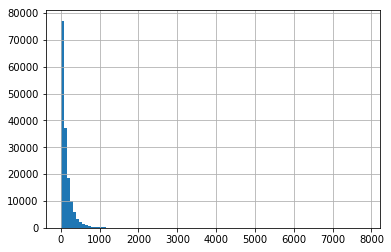

In [88]:
# Распределение review по количеству символов
data.review_text.str.len().hist(bins=100)

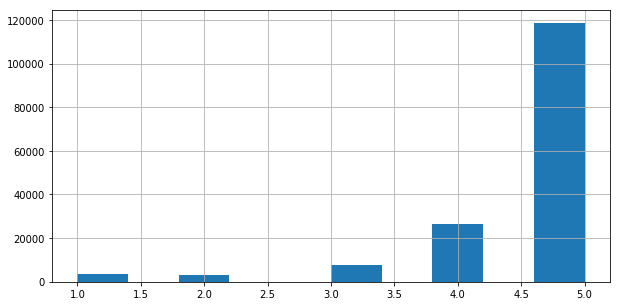

In [100]:
# Распределение review по количеству символов
#data.rating.value_counts().hist(bins=100)

# посмотрим на гистограмму распределения оценок по всем курсам
plt.rcParams['figure.figsize'] = (10, 5)
data.rating.hist()

In [97]:
# Три варианта положительных комментариев
for i, text in data[data.rating==5].head(3).iterrows():
    print("Good comment: \n {0} \n".format(text['review_text']))

Good comment: 
 Very relevant and useful course designed for CIOs 

Good comment: 
 Great piece of work, I especially liked a few 'lifehacks' for the CIO 

Good comment: 
 Excellent course, for me it was very rewarding and the terms used and the tools given were excellent, and today and I put in use in my job, Thank you for inculcating knowledge and move on               



In [102]:
# Три варианта отрицательных(негативных) комментариев
for i, text in data[data.rating==1].head(3).iterrows():
    print("Bad comment: \n {0} \n".format(text['review_text']))

Bad comment: 
 Till now no assigment for my work on week 4. 

Bad comment: 
 This course doesn't contain any new information. It does not teach you but just excitedly shows commonly known facts.There are better ways to invest your time. 

Bad comment: 
 I do not find very interesting this course. too many interviews. It could works for the first course, but not for the second. I was expecting to have more technical material and lessons. 



### Токенизация и очистка данных

Сделаем токенизацию слов из текстов review

In [103]:
mystopwords = stopwords.words('english') + ["i'm", '-', "i've"]
regex = re.compile("['A-Za-z\-]+")

def tokenize(text, regex=regex, stopwords=mystopwords):
    """ Tokenize all tokens from text string
        Returns array of tokens
    """
    try:
        text = " ".join(regex.findall(text)).lower()
        tokens = ' '.join([token for token in text.split(' ') if not token in stopwords])
        return tokens
    except:
        return []

In [104]:
data['review_text_tokenize'] = data.review_text.apply(tokenize)

In [105]:
data.head()

,course_id,reviewer_name,rating,review_text,title,topics,about,instructors,language,metrics,product_glance,average_score,ratings_count,reviews_count,skills,syllabus,recommendations,url,review_text_tokenize
0,2-speed-it,Ravish,5,Very relevant and useful course designed for CIOs,Two Speed IT: How Companies Can Surf the Digit...,"['Business', 'Business Essentials']","Transform or disappear, the Darwinism of IT: I...","['Antoine Gourévitch', 'Vanessa Lyon', 'Eric B...",English,"['16,728 already enrolled!', '5,149 recent vie...","['100% online', 'Flexible deadlines', 'Approx....",4.4,33,33,[],"['Introduction', 'IT and the CIO in the Digita...","['fundamentals-of-management', 'entrepreneuria...",https://www.coursera.org/learn/2-speed-it,relevant useful course designed cios
1,2-speed-it,Etienne R,2,This course does not say anything about digiti...,Two Speed IT: How Companies Can Surf the Digit...,"['Business', 'Business Essentials']","Transform or disappear, the Darwinism of IT: I...","['Antoine Gourévitch', 'Vanessa Lyon', 'Eric B...",English,"['16,728 already enrolled!', '5,149 recent vie...","['100% online', 'Flexible deadlines', 'Approx....",4.4,33,33,[],"['Introduction', 'IT and the CIO in the Digita...","['fundamentals-of-management', 'entrepreneuria...",https://www.coursera.org/learn/2-speed-it,course say anything digitization core subject ...
2,2-speed-it,Viswas P,4,Videos that are presented in French could've b...,Two Speed IT: How Companies Can Surf the Digit...,"['Business', 'Business Essentials']","Transform or disappear, the Darwinism of IT: I...","['Antoine Gourévitch', 'Vanessa Lyon', 'Eric B...",English,"['16,728 already enrolled!', '5,149 recent vie...","['100% online', 'Flexible deadlines', 'Approx....",4.4,33,33,[],"['Introduction', 'IT and the CIO in the Digita...","['fundamentals-of-management', 'entrepreneuria...",https://www.coursera.org/learn/2-speed-it,videos presented french could've translated en...
3,2-speed-it,AN L,3,"The course content is quite good, though it co...",Two Speed IT: How Companies Can Surf the Digit...,"['Business', 'Business Essentials']","Transform or disappear, the Darwinism of IT: I...","['Antoine Gourévitch', 'Vanessa Lyon', 'Eric B...",English,"['16,728 already enrolled!', '5,149 recent vie...","['100% online', 'Flexible deadlines', 'Approx....",4.4,33,33,[],"['Introduction', 'IT and the CIO in the Digita...","['fundamentals-of-management', 'entrepreneuria...",https://www.coursera.org/learn/2-speed-it,course content quite good though could deeper ...
4,2-speed-it,Konstantin A,5,"Great piece of work, I especially liked a few ...",Two Speed IT: How Companies Can Surf the Digit...,"['Business', 'Business Essentials']","Transform or disappear, the Darwinism of IT: I...","['Antoine Gourévitch', 'Vanessa Lyon', 'Eric B...",English,"['16,728 already enrolled!', '5,149 recent vie...","['100% online', 'Flexible deadlines', 'Approx....",4.4,33,33,[],"['Introduction', 'IT and the CIO in the Digita...","['fundamentals-of-management', 'entrepreneuria...",https://www.coursera.org/learn/2-speed-it,great piece work especially liked 'lifehacks' cio


### Определим частоту слов построим облако слов для того чтобы понять о чем большинство текстов

In [107]:
from collections import Counter

lemmata = []
for index, row in data.iterrows():
    lemmata += row['review_text_tokenize'].split()
cnt = Counter(lemmata)

for i in cnt.most_common(15):
    print(i)

('course', 115010)
('great', 33413)
('good', 29760)
('really', 18212)
('excellent', 15854)
('lot', 14015)
('well', 13973)
('interesting', 12864)
('would', 11913)
('thank', 11565)
('much', 11430)
('learn', 9470)
('like', 9359)
('useful', 9270)
('one', 8951)


In [110]:
# Количество слов в словаре:
print(len(cnt))

53814


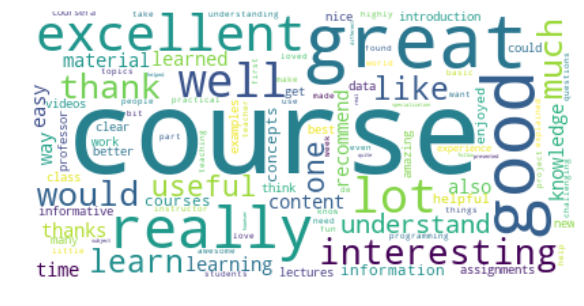

In [111]:
from wordcloud import *
word_freq = [i for i in cnt.most_common(100)]
wd = WordCloud(background_color = 'white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### Сформируем сбалансированный датасет c обучающей и тестовой выборкой
Поскольку датасет несбалансирован, применим Undersampling подход

In [ ]:
№№№№№№№№№№№№№
### бинарную классификацию в многоклассовую!!!!!!!!!!!!

In [112]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)

X = data[['review_text_tokenize']]
y = data['rating']

X_balanced, y_balanced = rus.fit_resample(X, y)

In [113]:
balanced = pd.DataFrame.from_dict({'review_text_tokenize': X_balanced[:,0], 'rating': y_balanced}) 
balanced.head()

,review_text_tokenize,rating
0,material extremely fragmented seems like instr...,1
1,poor design presentation assignment,1
2,totally unsufficient guidance external tools n...,1
3,find course added anything already learned see...,1
4,pesimo,1


In [114]:
# Сделаем обучающую и тестовую выборку
train, test = train_test_split(balanced, test_size=0.2, random_state=42)

### Построим векторную модель с помощью Doc2Vec

для предсказания пользовательских оценок

In [115]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [117]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=r['review_text_tokenize'].split(' '), tags=[r.rating]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=r['review_text_tokenize'].split(' '), tags=[r.rating]), axis=1)

In [118]:
train_tagged.values[30]

TaggedDocument(words=['interesting', 'course', 'way', 'many', 'quizzes', 'extremely', 'tedious', 'would', 'recommend', 'course', 'anyone'], tags=[2])

In [119]:
model_dbow = Doc2Vec(dm=0, vector_size=2000, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 13028/13028 [00:00<00:00, 2452575.97it/s]


In [120]:
# Обучаем модель
for epoch in range(10):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 13028/13028 [00:00<00:00, 3142953.67it/s]


In [121]:
# Сформируем итоговый набор векторов для обучения
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [122]:
## Логистическая регрессия

In [123]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [124]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [125]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.3997543751918944
Testing F1 score: 0.39778536029224326
